In [ ]:
!pip install torch torchvision pycocotools numpy matplotlib opencv-python

In [ ]:
!pip install albumentations segmentation-models-pytorch

In [14]:
import os
import json
from PIL import Image, ImageDraw
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

class FruitsDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = [f for f in os.listdir(root) if f.endswith('.jpg')]
        self.annotations = json.load(open(os.path.join(root, "_annotations.coco.json")))
        self.img_id_to_idx = {img['id']: img['file_name'] for img in self.annotations['images']}
        self.cat_id_to_name = {cat['id']: cat['name'] for cat in self.annotations['categories']}
        self.cat_id_to_idx = {cat['id']: idx for idx, cat in enumerate(self.annotations['categories'])}

    def __getitem__(self, idx):
        img_name = self.img_id_to_idx[idx]
        img_path = os.path.join(self.root, img_name)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)

        masks = np.zeros((len(self.annotations["categories"]), img.shape[0], img.shape[1]), dtype=np.uint8)
        for ann in self.annotations["annotations"]:
            if ann["image_id"] == idx:
                category_id = ann['category_id']
                if ann['segmentation']:  # Ensure segmentation exists
                    for segmentation in ann['segmentation']:
                        mask = Image.new('L', (img.shape[1], img.shape[0]), 0)
                        ImageDraw.Draw(mask).polygon(segmentation, outline=1, fill=1)
                        masks[self.cat_id_to_idx[category_id]] = np.maximum(masks[self.cat_id_to_idx[category_id]], np.array(mask))

        if self.transforms:
            transformed = self.transforms(image=img, masks=list(masks))
            img = transformed["image"]
            masks = torch.stack([torch.as_tensor(m) for m in transformed["masks"]])

        return img, masks

    def __len__(self):
        return len(self.imgs)

# Augmentations
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_dataset = FruitsDataset(root='./Fruits-by-YOLO-1/train', transforms=transform)
test_dataset = FruitsDataset(root='./Fruits-by-YOLO-1/test', transforms=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=10, activation=None)

loss_fn = smp.losses.DiceLoss(smp.losses.MULTILABEL_MODE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    val_loss = 0
    
    with torch.no_grad():
        for imgs, masks in tqdm.tqdm(data_loader):
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)
            outputs = torch.sigmoid(outputs)
            preds = (outputs > 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(masks.cpu().numpy())
            
            val_loss += loss_fn(outputs, masks).item()

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Flatten the masks to compute metrics
    all_preds = all_preds.reshape(-1, all_preds.shape[1])
    all_labels = all_labels.reshape(-1, all_labels.shape[1])

    # Slice the arrays to reduce size (taking every 10th element)
    all_preds = all_preds[::10]
    all_labels = all_labels[::10]

    f1 = f1_score(all_labels, all_preds, average='weighted')
    val_loss /= len(data_loader)
    return val_loss, f1

train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    
    for imgs, masks in tqdm.tqdm(train_loader):
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

        outputs = torch.sigmoid(outputs)
        preds = (outputs > 0.5).float()
        all_preds.append(preds.cpu().numpy())
        all_labels.append(masks.cpu().numpy())
    
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Flatten the masks to compute metrics
    all_preds = all_preds.reshape(-1, all_preds.shape[1])
    all_labels = all_labels.reshape(-1, all_labels.shape[1])

    # Slice the arrays to reduce size (taking every 10th element)
    all_preds = all_preds[::10]
    all_labels = all_labels[::10]

    train_f1 = f1_score(all_labels, all_preds, average='weighted')
    train_f1s.append(train_f1)

    val_loss, val_f1 = evaluate_model(model, test_loader, device)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

torch.save(model.state_dict(), "unet_fruits_segmentation.pth")

100%|██████████| 12/12 [00:01<00:00,  6.86it/s]


Epoch 1/30, Train Loss: 0.4153, Val Loss: 0.3783, Train F1: 0.1800, Val F1: 0.2761


100%|██████████| 12/12 [00:01<00:00,  8.01it/s]


Epoch 2/30, Train Loss: 0.3195, Val Loss: 0.3758, Train F1: 0.2975, Val F1: 0.3408


100%|██████████| 12/12 [00:01<00:00,  7.08it/s]


Epoch 3/30, Train Loss: 0.2507, Val Loss: 0.3732, Train F1: 0.3598, Val F1: 0.4629


100%|██████████| 12/12 [00:01<00:00,  7.37it/s]


Epoch 4/30, Train Loss: 0.2127, Val Loss: 0.3719, Train F1: 0.3867, Val F1: 0.4883


100%|██████████| 12/12 [00:01<00:00,  6.35it/s]


Epoch 5/30, Train Loss: 0.1829, Val Loss: 0.3731, Train F1: 0.4575, Val F1: 0.5592


100%|██████████| 12/12 [00:01<00:00,  6.52it/s]


Epoch 6/30, Train Loss: 0.1521, Val Loss: 0.3722, Train F1: 0.5031, Val F1: 0.6142


100%|██████████| 12/12 [00:02<00:00,  5.75it/s]


Epoch 7/30, Train Loss: 0.1346, Val Loss: 0.3713, Train F1: 0.5295, Val F1: 0.6250


100%|██████████| 12/12 [00:01<00:00,  6.70it/s]


Epoch 8/30, Train Loss: 0.1272, Val Loss: 0.3732, Train F1: 0.5425, Val F1: 0.5736


100%|██████████| 12/12 [00:01<00:00,  7.46it/s]


Epoch 9/30, Train Loss: 0.1335, Val Loss: 0.3726, Train F1: 0.5304, Val F1: 0.6583


100%|██████████| 12/12 [00:01<00:00,  6.10it/s]


Epoch 10/30, Train Loss: 0.1144, Val Loss: 0.3721, Train F1: 0.5713, Val F1: 0.6484


100%|██████████| 12/12 [00:01<00:00,  6.28it/s]


Epoch 11/30, Train Loss: 0.1057, Val Loss: 0.3719, Train F1: 0.5933, Val F1: 0.6571


100%|██████████| 12/12 [00:01<00:00,  7.20it/s]


Epoch 12/30, Train Loss: 0.1045, Val Loss: 0.3722, Train F1: 0.5932, Val F1: 0.6502


100%|██████████| 12/12 [00:01<00:00,  8.66it/s]


Epoch 13/30, Train Loss: 0.0970, Val Loss: 0.3718, Train F1: 0.6118, Val F1: 0.6928


100%|██████████| 12/12 [00:01<00:00,  7.10it/s]


Epoch 14/30, Train Loss: 0.0881, Val Loss: 0.3713, Train F1: 0.6251, Val F1: 0.6845


100%|██████████| 12/12 [00:01<00:00,  6.73it/s]


Epoch 15/30, Train Loss: 0.0813, Val Loss: 0.3710, Train F1: 0.6409, Val F1: 0.6978


100%|██████████| 12/12 [00:01<00:00,  7.11it/s]


Epoch 16/30, Train Loss: 0.0829, Val Loss: 0.3729, Train F1: 0.6362, Val F1: 0.6463


100%|██████████| 12/12 [00:01<00:00,  7.85it/s]


Epoch 17/30, Train Loss: 0.0930, Val Loss: 0.3727, Train F1: 0.6086, Val F1: 0.6586


100%|██████████| 12/12 [00:01<00:00,  7.12it/s]


Epoch 18/30, Train Loss: 0.0941, Val Loss: 0.3713, Train F1: 0.6142, Val F1: 0.6453


100%|██████████| 12/12 [00:01<00:00,  6.97it/s]


Epoch 19/30, Train Loss: 0.0831, Val Loss: 0.3706, Train F1: 0.6375, Val F1: 0.6797


100%|██████████| 12/12 [00:01<00:00,  6.49it/s]


Epoch 20/30, Train Loss: 0.0745, Val Loss: 0.3700, Train F1: 0.6475, Val F1: 0.6940


100%|██████████| 12/12 [00:02<00:00,  5.93it/s]


Epoch 21/30, Train Loss: 0.0735, Val Loss: 0.3703, Train F1: 0.6486, Val F1: 0.6989


100%|██████████| 12/12 [00:01<00:00,  8.12it/s]


Epoch 22/30, Train Loss: 0.0798, Val Loss: 0.3715, Train F1: 0.6386, Val F1: 0.6749


100%|██████████| 12/12 [00:01<00:00,  6.60it/s]


Epoch 23/30, Train Loss: 0.0745, Val Loss: 0.3713, Train F1: 0.6506, Val F1: 0.7130


100%|██████████| 12/12 [00:01<00:00,  7.67it/s]


Epoch 24/30, Train Loss: 0.0729, Val Loss: 0.3717, Train F1: 0.6501, Val F1: 0.6846


100%|██████████| 12/12 [00:01<00:00,  8.02it/s]


Epoch 25/30, Train Loss: 0.0758, Val Loss: 0.3720, Train F1: 0.6382, Val F1: 0.6745


100%|██████████| 12/12 [00:01<00:00,  6.72it/s]


Epoch 26/30, Train Loss: 0.0660, Val Loss: 0.3749, Train F1: 0.6574, Val F1: 0.6364


100%|██████████| 12/12 [00:01<00:00,  6.64it/s]


Epoch 27/30, Train Loss: 0.0691, Val Loss: 0.3716, Train F1: 0.6523, Val F1: 0.6964


100%|██████████| 12/12 [00:01<00:00,  7.11it/s]


Epoch 28/30, Train Loss: 0.0632, Val Loss: 0.3725, Train F1: 0.6674, Val F1: 0.6729


100%|██████████| 12/12 [00:01<00:00,  6.46it/s]


Epoch 29/30, Train Loss: 0.0595, Val Loss: 0.3712, Train F1: 0.6668, Val F1: 0.7215


100%|██████████| 12/12 [00:01<00:00,  6.88it/s]


Epoch 30/30, Train Loss: 0.0626, Val Loss: 0.3716, Train F1: 0.6661, Val F1: 0.7098


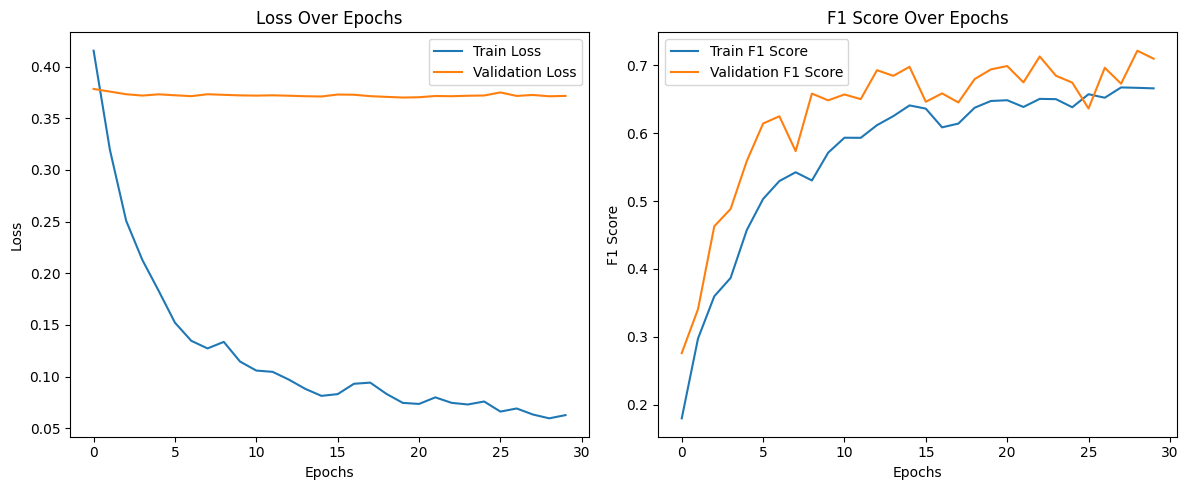

In [14]:
# Plotting the metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_f1s, label='Train F1 Score')
plt.plot(range(num_epochs), val_f1s, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.title('F1 Score Over Epochs')

plt.tight_layout()
plt.show()

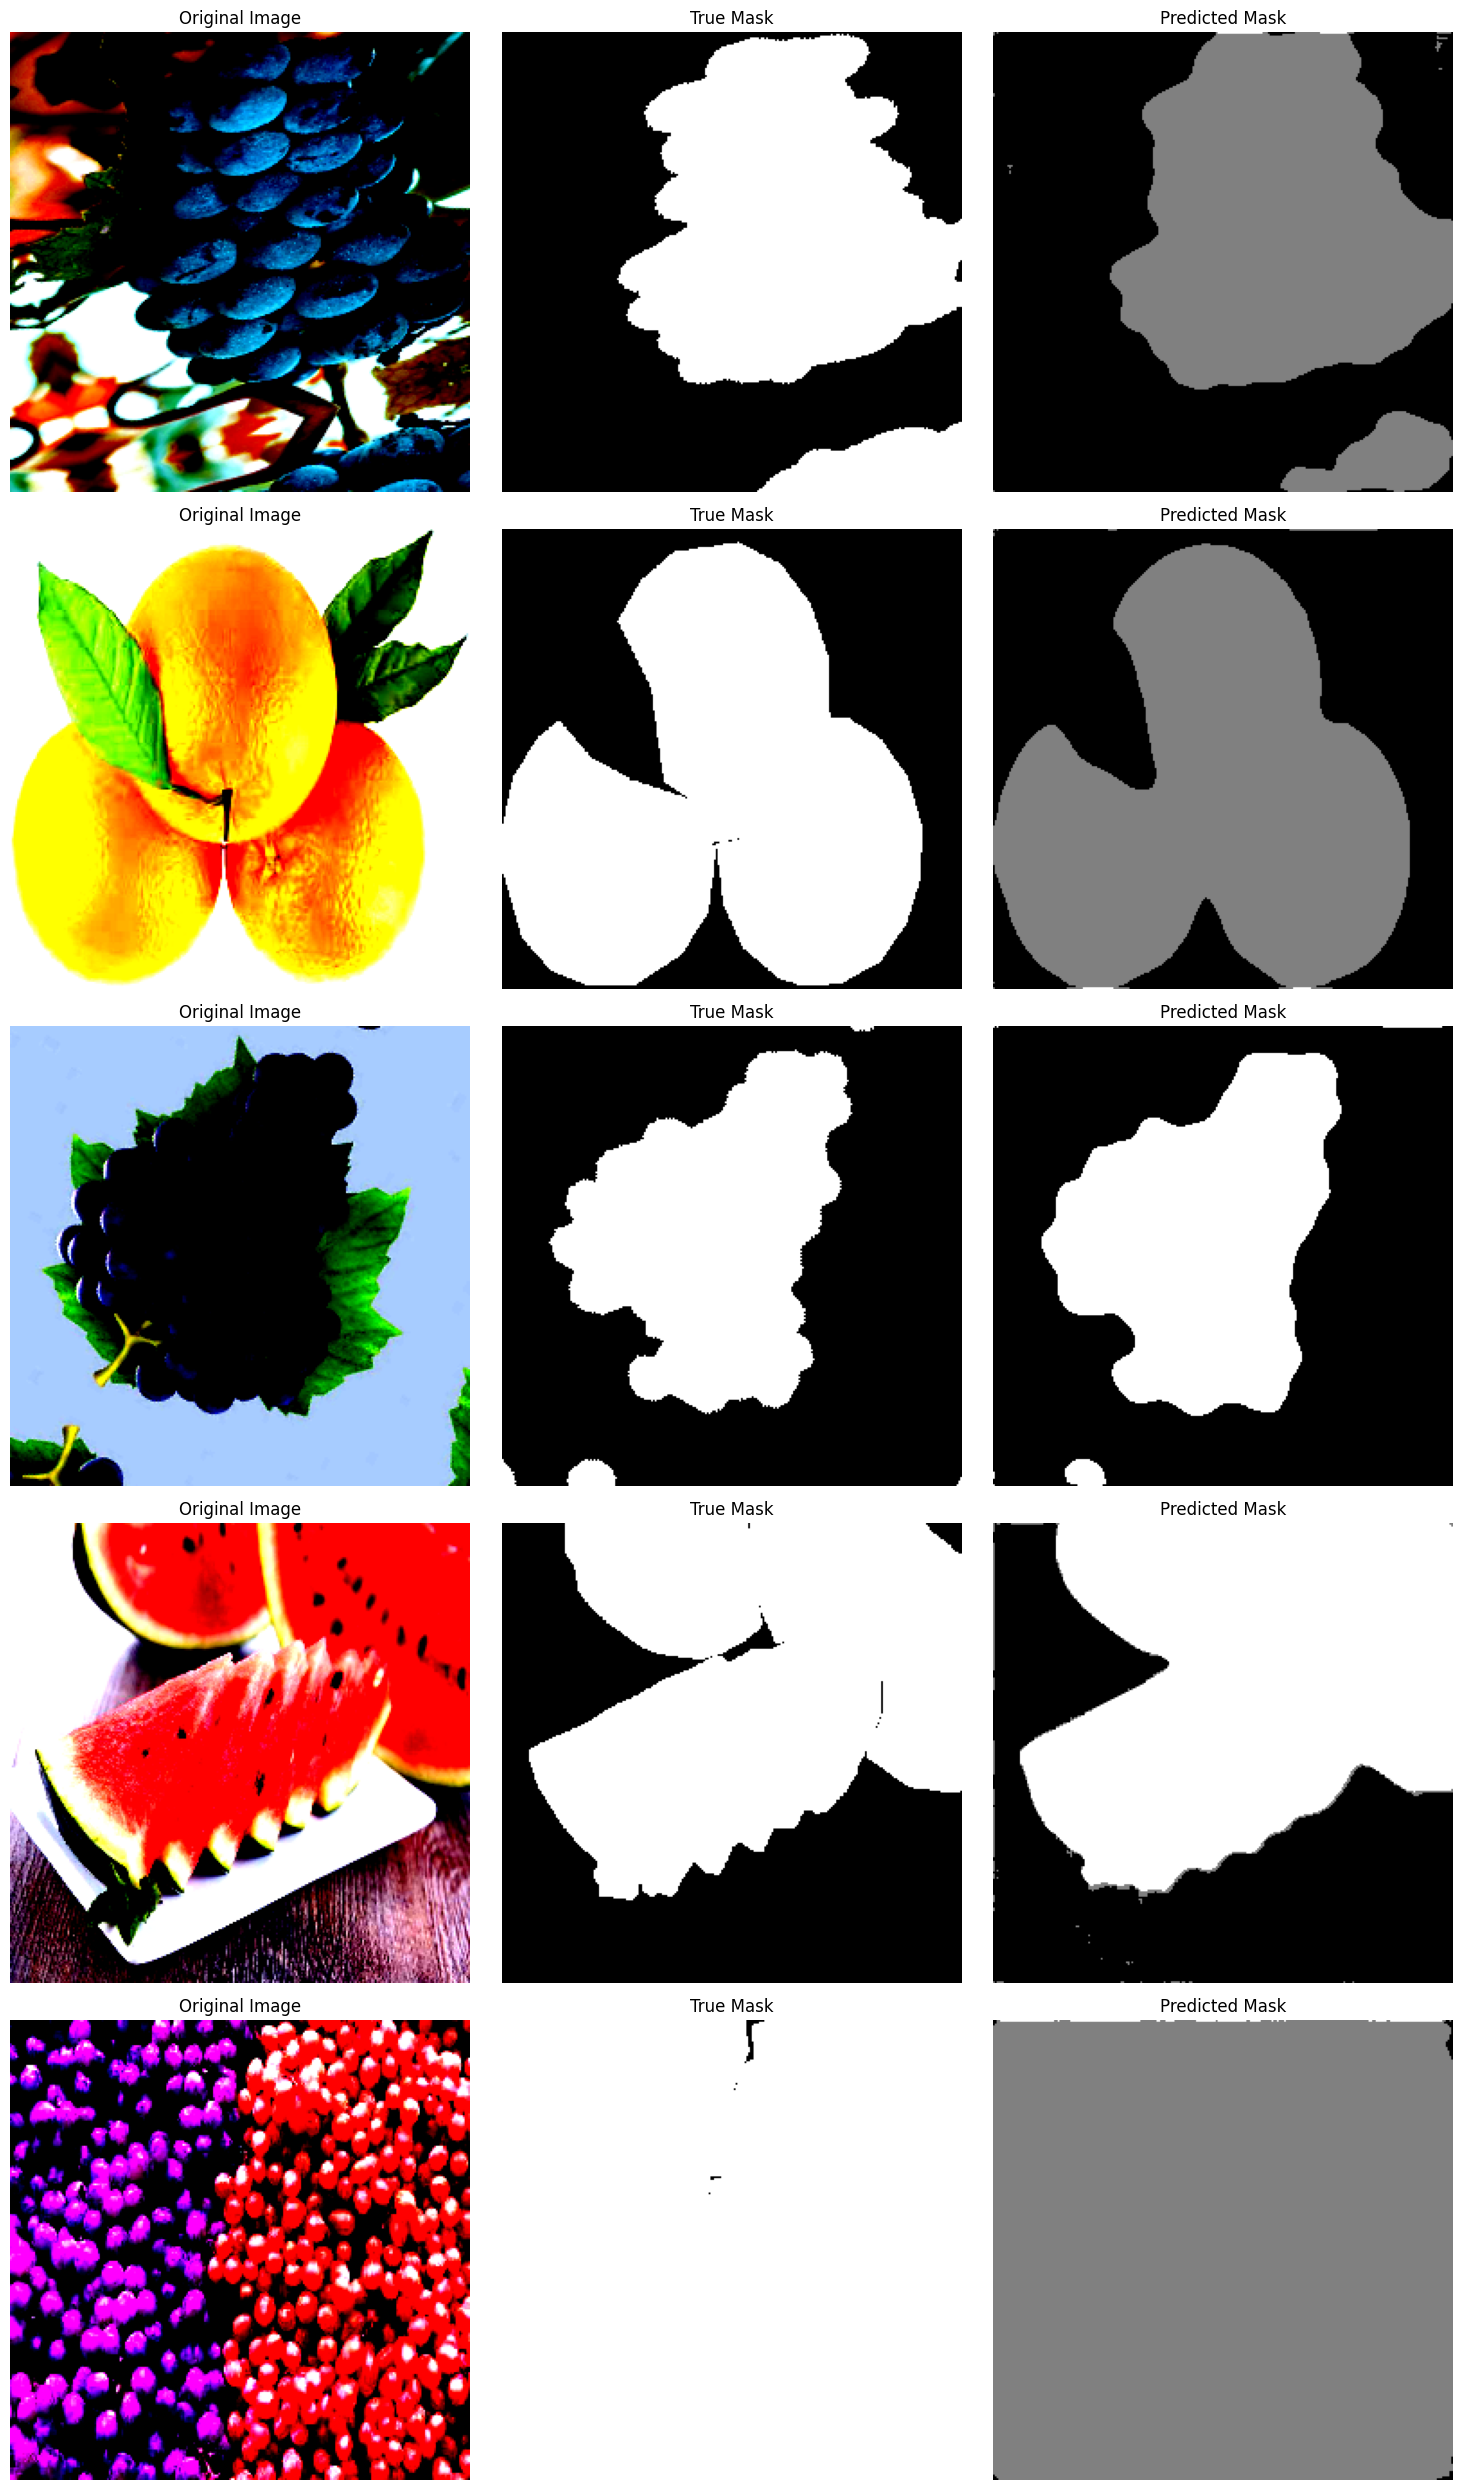

In [15]:

def visualize_predictions(model, data_loader, device, num_images=5):
    model.eval()
    images, true_masks, pred_masks = [], [], []
    
    with torch.no_grad():
        for imgs, masks in data_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)
            outputs = torch.sigmoid(outputs)
            preds = (outputs > 0.5).float()
            
            images.extend(imgs.cpu().numpy())
            true_masks.extend(masks.cpu().numpy())
            pred_masks.extend(preds.cpu().numpy())
            
            if len(images) >= num_images:
                break

    # Görüntü ve maskeleri görselleştir
    fig, ax = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    for i in range(num_images):
        img = images[i].transpose(1, 2, 0)
        true_mask = np.sum(true_masks[i], axis=0)
        pred_mask = np.sum(pred_masks[i], axis=0)
        
        ax[i, 0].imshow(img)
        ax[i, 0].set_title("Original Image")
        ax[i, 0].axis('off')

        ax[i, 1].imshow(true_mask, cmap='gray')
        ax[i, 1].set_title("True Mask")
        ax[i, 1].axis('off')

        ax[i, 2].imshow(pred_mask, cmap='gray')
        ax[i, 2].set_title("Predicted Mask")
        ax[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Modelin tahminlerini görselleştirme
visualize_predictions(model, test_loader, device, num_images=5)

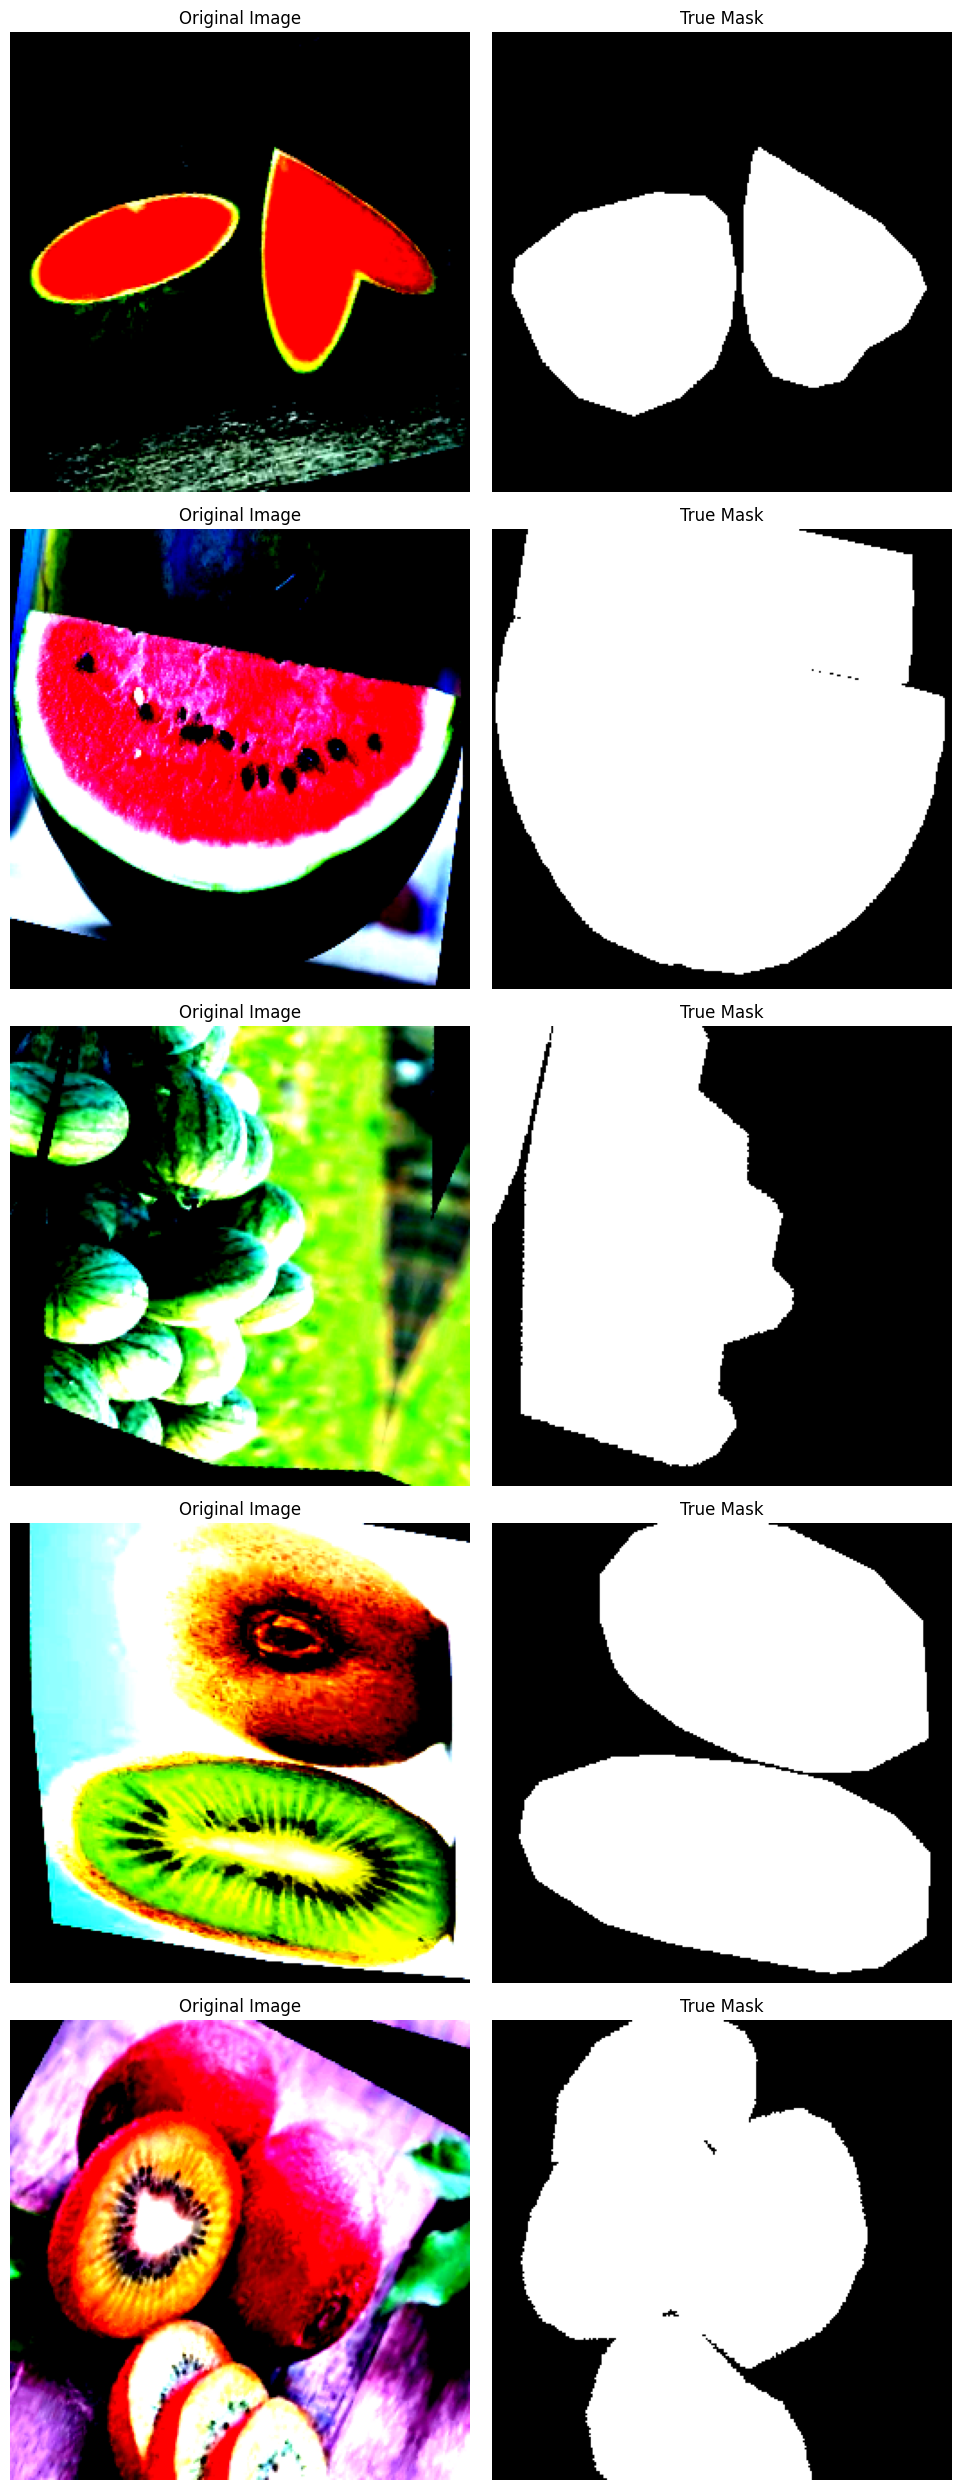

In [16]:
def visualize_dataset(data_loader, num_images=5):
    images, true_masks = [], []
    
    for imgs, masks in data_loader:
        images.extend(imgs.cpu().numpy())
        true_masks.extend(masks.cpu().numpy())
        
        if len(images) >= num_images:
            break

    # Görüntü ve maskeleri görselleştir
    fig, ax = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    for i in range(num_images):
        img = images[i].transpose(1, 2, 0)
        true_mask = np.sum(true_masks[i], axis=0)
        
        ax[i, 0].imshow(img)
        ax[i, 0].set_title("Original Image")
        ax[i, 0].axis('off')

        ax[i, 1].imshow(true_mask, cmap='gray')
        ax[i, 1].set_title("True Mask")
        ax[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Veri setinin maskelerini görselleştirme
visualize_dataset(train_loader, num_images=5)